# Earth2MIP Demo - Custom Datasets

**Installation**

* [apex](https://github.com/NVIDIA/apex#quick-start)

In [62]:
import numpy as np
import cdsapi
from pathlib import Path
import xarray as xr
import autoroot
import datetime
from earth2mip import inference_ensemble, registry
from earth2mip.networks import get_model
from earth2mip.initial_conditions import cds
from earth2mip.inference_ensemble import run_basic_inference
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from bayesevt._src.data.ics import LocalDataSourceXArray

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model

First, we need to select a model.
This will depend on what you choose to install. 
I personally chose the `FourCastNet` model because it is the most flexible in terms of resolution (in theory). 
But in principal, we could choose other models but it would depend on the variables.

In [2]:
model_name = "fcnv2_sm" 

We have Get channel names without saving the model

In [3]:
from bayesevt._src.models.earth2mip import EARTH2MIP_MODEL_VARIABLES

channel_names = EARTH2MIP_MODEL_VARIABLES["fcnv2_sm"]
channel_names = EARTH2MIP_MODEL_VARIABLES[model_name]

First, we need to load the model and put it to some processor, either `cpu` or some `cuda:x` device.

**Warning**: CPU is very slow even for inference.
It's not recommended.

In [4]:
model = f"e2mip://{model_name}"
device = "cuda:1"

We initialize a special `earth2mip.networks.Inference` datastructure which has a host of different features for making predictions.
The most important thing is initializing a model from their registry or a custom model. 
And of course the device

In [5]:
time_loop  = get_model(
    model=model,
    device=device,
)

In [6]:
channel_names = time_loop.in_channel_names
# channel_names

***

## Initial Condition

We need to do an initial condition to propagate the data forward.
We will use a special `dataclass` which defines all of the parameters we need to load data from an `xarray.Dataset`.
This should include `.netcdf`, `.grib`, and `.grib`. 
As long as we can define the xarray engine and it follows some standards, we should be able to load it.

**Parameters**

* `t0` - `datetime` object with a time period.
* `num_steps` - the number of time steps (6h intervals)

In [134]:
# starting timestep
t0 = datetime.datetime(2018,7,30)

# number of forecast steps
num_steps = 4 * 12 # 6h intervals

## Custom Datasets

### NETCDF Files

Our first example will have a custom `.netcdf` file where we already have the variables available.

In [135]:
save_name = "reanalysis_20180715_20180830_ics_v2"

file_paths = [
    f"/pool/proyectos/CLINT/sa4attrs/data/raw/events/{save_name}.nc"
]

In [136]:
ds = xr.open_mfdataset(file_paths, combine="by_coords", engine="netcdf4")
ds

<xarray.Dataset> Size: 9GB
Dimensions:                    (time: 22, latitude: 721, longitude: 1440,
                                level: 13)
Coordinates:
  * latitude                   (latitude) float32 3kB 90.0 89.75 ... -90.0
  * level                      (level) int64 104B 100 200 1000 ... 250 700 925
  * longitude                  (longitude) float32 6kB 0.0 0.25 ... 359.5 359.8
  * time                       (time) datetime64[ns] 176B 2018-07-20 ... 2018...
Data variables: (12/14)
    10m_v_component_of_wind    (time, latitude, longitude) float32 91MB dask.array<chunksize=(22, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind   (time, latitude, longitude) float32 91MB dask.array<chunksize=(22, 721, 1440), meta=np.ndarray>
    surface_pressure           (time, latitude, longitude) float32 91MB dask.array<chunksize=(22, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind    (time, latitude, longitude) float32 91MB dask.array<chunksize=(22, 721, 1440), meta=np.ndarray>
    total_column_water_vapour  (time, latitude, longitude) float32 91MB dask.array<chunksize=(22, 721, 1440), meta=np.ndarray>
    2m_temperature             (time, latitude, longitude) float32 91MB dask.array<chunksize=(22, 721, 1440), meta=np.ndarray>
    ...                         ...
    specific_humidity          (time, level, latitude, longitude) float32 1GB dask.array<chunksize=(22, 13, 721, 1440), meta=np.ndarray>
    temperature                (time, level, latitude, longitude) float32 1GB dask.array<chunksize=(22, 13, 721, 1440), meta=np.ndarray>
    geopotential               (time, level, latitude, longitude) float32 1GB dask.array<chunksize=(22, 13, 721, 1440), meta=np.ndarray>
    u_component_of_wind        (time, level, latitude, longitude) float32 1GB dask.array<chunksize=(22, 13, 721, 1440), meta=np.ndarray>
    v_component_of_wind        (time, level, latitude, longitude) float32 1GB dask.array<chunksize=(22, 13, 721, 1440), meta=np.ndarray>
    relative_humidity          (time, level, latitude, longitude) float64 2GB dask.array<chunksize=(22, 13, 721, 1440), meta=np.ndarray>

#### Parameters

We have some key parameters we need to set when dealing with this dataset.

**Name Convention**.
The name convention follows the *full name*, e.g., "10m_u_component_of_wind". This convention is set by the CDS.
We have a database within the library for all variables that are related to the AI models so it will recognize all names and do the translation even though we provided a list of `channel_names` which have the short form format.

**Pressure Name**.
We need to specify what is the pressure level name. 
This varies across datasets so the user can manually specify it to match theirs.

**Engine**.
We use the native `xarray.open_mfdataset(..., engine=...)` function.
So we are free to specify whichever engine that is our dataset format.
Even though this example uses `.netcdf`, we are also compatible with whichever formats are available.

In [137]:
# initial condition
data_source_xr = LocalDataSourceXArray(
    channel_names=channel_names,
    file_paths=file_paths,
    pressure_name="level", 
    name_convention="era5_name",
    engine="netcdf4", 
    
)

In [138]:
out_xr = data_source_xr[t0]

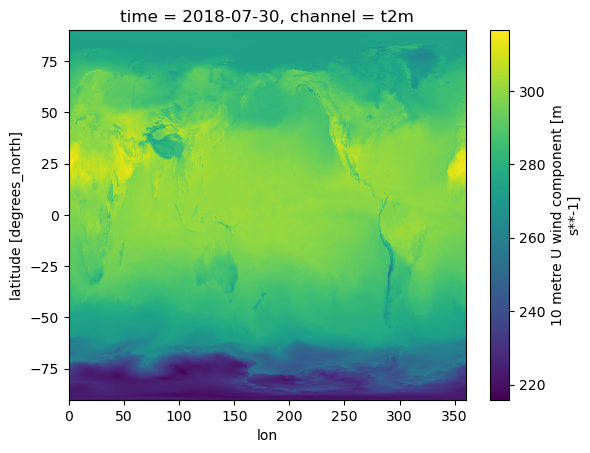

In [139]:
out_xr.sel(channel="t2m").plot()

## Inference Loop

These are the same steps as the previous tutorial.

In [140]:
%%time
ds = run_basic_inference(
    time_loop, 
    n=num_steps, 
    data_source=data_source_xr, 
    time=t0
)

CPU times: user 14.7 s, sys: 24.8 s, total: 39.5 s
Wall time: 40.3 s


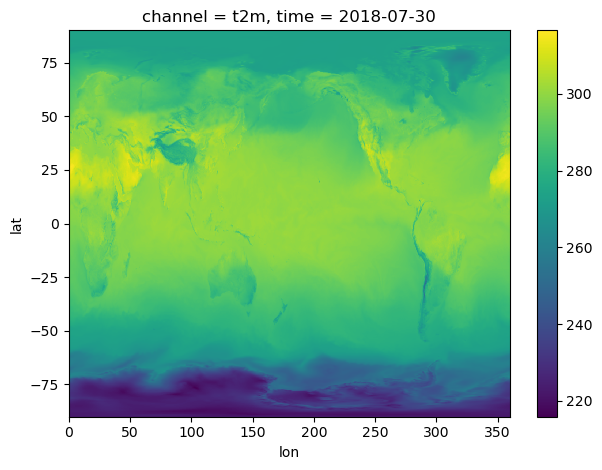

In [141]:
fig, ax = plt.subplots()
ds.sel(channel="t2m").isel(time=0).squeeze().plot.pcolormesh(ax=ax)
plt.tight_layout()
plt.show()

## Compare: ERA5 Data

We will compare this with the previous dataset with one we can call online. 
In theory, it should be the exact same dataset but we are going to download it from the CDS.

In [142]:
ds_true = xr.open_mfdataset(file_paths, engine="netcdf4")
ds_true

<xarray.Dataset> Size: 9GB
Dimensions:                    (time: 22, latitude: 721, longitude: 1440,
                                level: 13)
Coordinates:
  * latitude                   (latitude) float32 3kB 90.0 89.75 ... -90.0
  * level                      (level) int64 104B 100 200 1000 ... 250 700 925
  * longitude                  (longitude) float32 6kB 0.0 0.25 ... 359.5 359.8
  * time                       (time) datetime64[ns] 176B 2018-07-20 ... 2018...
Data variables: (12/14)
    10m_v_component_of_wind    (time, latitude, longitude) float32 91MB dask.array<chunksize=(22, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind   (time, latitude, longitude) float32 91MB dask.array<chunksize=(22, 721, 1440), meta=np.ndarray>
    surface_pressure           (time, latitude, longitude) float32 91MB dask.array<chunksize=(22, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind    (time, latitude, longitude) float32 91MB dask.array<chunksize=(22, 721, 1440), meta=np.ndarray>
    total_column_water_vapour  (time, latitude, longitude) float32 91MB dask.array<chunksize=(22, 721, 1440), meta=np.ndarray>
    2m_temperature             (time, latitude, longitude) float32 91MB dask.array<chunksize=(22, 721, 1440), meta=np.ndarray>
    ...                         ...
    specific_humidity          (time, level, latitude, longitude) float32 1GB dask.array<chunksize=(22, 13, 721, 1440), meta=np.ndarray>
    temperature                (time, level, latitude, longitude) float32 1GB dask.array<chunksize=(22, 13, 721, 1440), meta=np.ndarray>
    geopotential               (time, level, latitude, longitude) float32 1GB dask.array<chunksize=(22, 13, 721, 1440), meta=np.ndarray>
    u_component_of_wind        (time, level, latitude, longitude) float32 1GB dask.array<chunksize=(22, 13, 721, 1440), meta=np.ndarray>
    v_component_of_wind        (time, level, latitude, longitude) float32 1GB dask.array<chunksize=(22, 13, 721, 1440), meta=np.ndarray>
    relative_humidity          (time, level, latitude, longitude) float64 2GB dask.array<chunksize=(22, 13, 721, 1440), meta=np.ndarray>

### Statistics

In [143]:
def where_slice(ds: xr.Dataset, variable: str, min_val: float, max_val: float, drop=True) -> xr.Dataset:

    ds = ds.where(
        (ds[variable] >= float(min_val)) & (ds[variable] <= float(max_val)),
        drop=drop
    )
        
    return ds

def post_process_temperature(ds, statistic: str=None):
    ds = ds.copy()
    # convert K to Degrees C
    ds = ds - 272.15
    # only select event
    ds = ds.sel(time=slice("2018-07-31","2018-08-11"))
    # rename coordinates
    try:
        ds = ds.rename({"lat": "latitude", "lon": "longitude"})
    except ValueError:
        pass
    # calculate 1D frequency
    
    ds = ds.resample(time="1D").median()
    # convert longitude coordinates
    ds["longitude"] =  (ds.longitude + 180) % 360 - 180
    # sort coordinates
    ds = ds.sortby("longitude").sortby("latitude")
    # select spain region
    ds = where_slice(ds, "longitude", min_val=-10, max_val=5)
    ds = where_slice(ds, "latitude", min_val=35, max_val=45)
    return ds

In [144]:
ds_t2m = post_process_temperature(ds.sel(channel="t2m").squeeze())
ds_true = post_process_temperature(ds_true["2m_temperature"])

## Visualization

In [145]:
def plot_temperature_facet(ds, label: str="Temperature", vmin=None, vmax=None, cmap: str="RdBu_r"):
    fig = ds.plot.pcolormesh(
        col="time", col_wrap=4, cmap=cmap,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(),
        subplot_kws={
            "projection": ccrs.PlateCarree(),
            "xlim":[ds.longitude.values.min(), ds.longitude.values.max()],
            "ylim": [ds.latitude.values.min(), ds.latitude.values.max()],
        },
        # usual xarray stuff
        cbar_kwargs={
            "orientation": "horizontal", 
            # "shrink": 0.8, "aspect": 40, 
            "fraction": 0.027, "pad": 0.045, "aspect": 40,
        },
        robust=False,
    )
    fig.map(lambda: plt.gca().coastlines())
    fig.cbar.set_label(label=f'{label} [°C]', size=20, weight='bold')
    # plt.tight_layout()
    plt.show()

    return fig

In [146]:
vmin, vmax = ds_true.min().values, ds_true.max().values
vmin -= - 0.02 * vmin
vmax += 0.02 * vmax

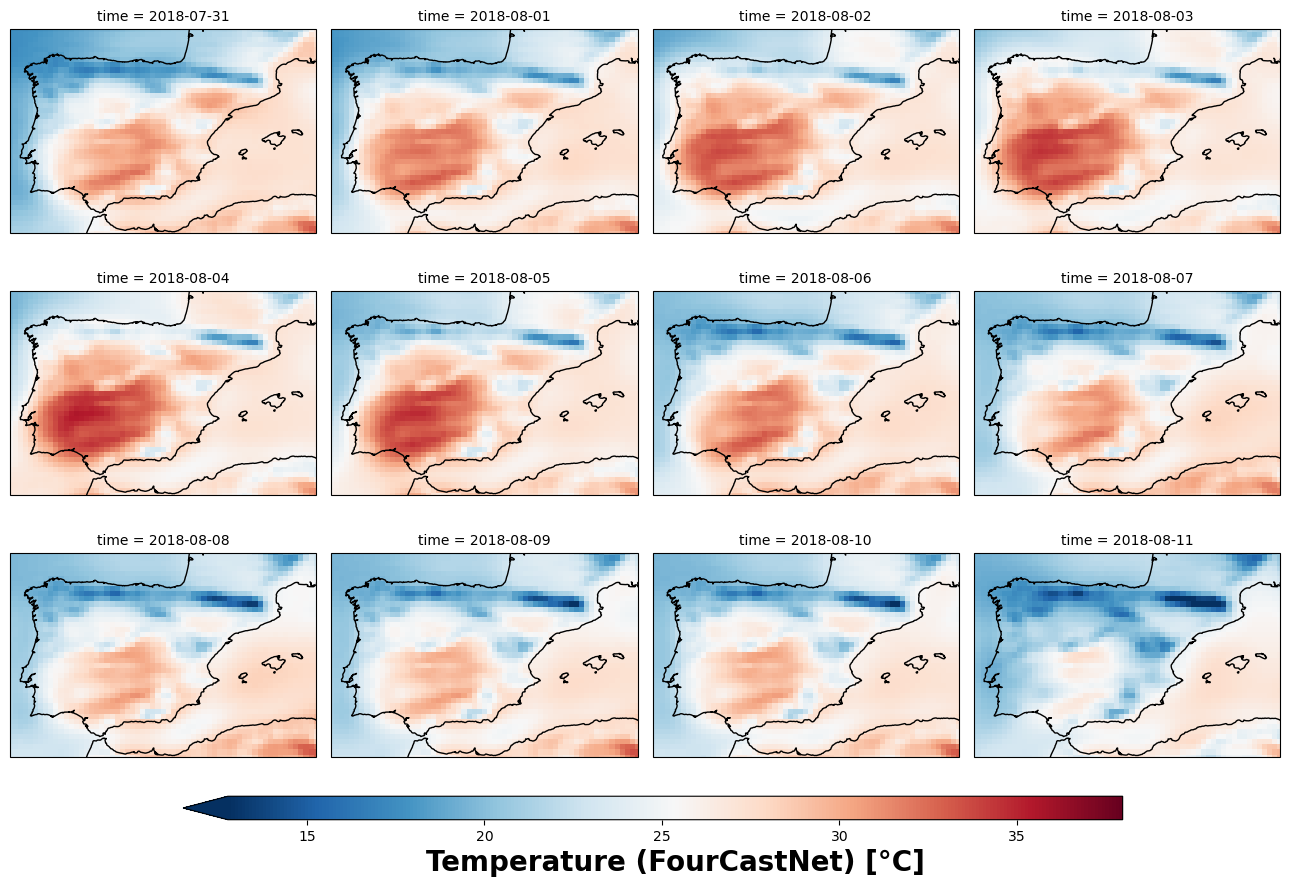

In [147]:
fig = plot_temperature_facet(ds_t2m, "Temperature (FourCastNet)", vmin=vmin, vmax=vmax)

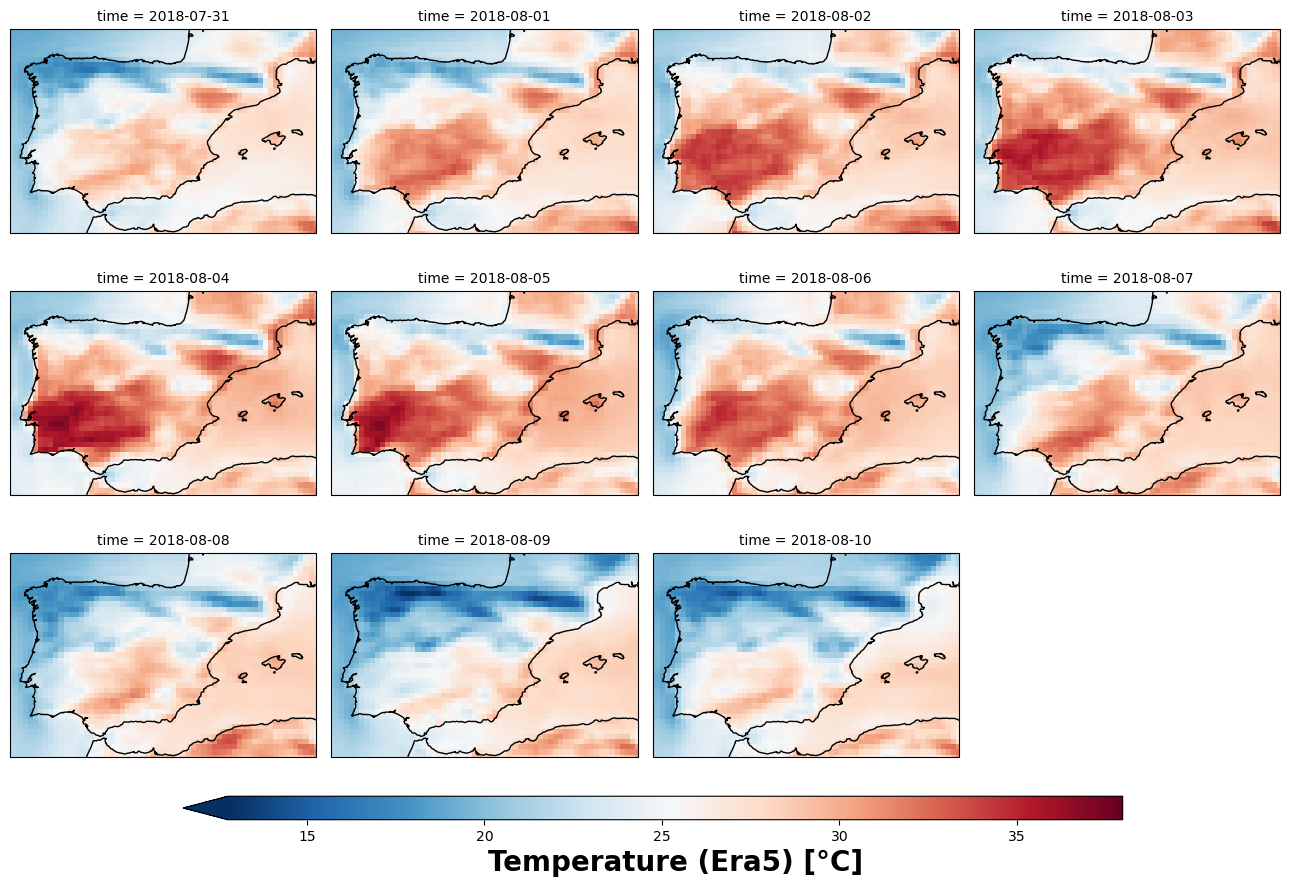

In [148]:
fig = plot_temperature_facet(ds_true, "Temperature (Era5)", vmin=vmin, vmax=vmax)

## Temporal Statistics

In [149]:
from bayesevt._src.geoprocessing.masks import add_country_mask, add_land_mask

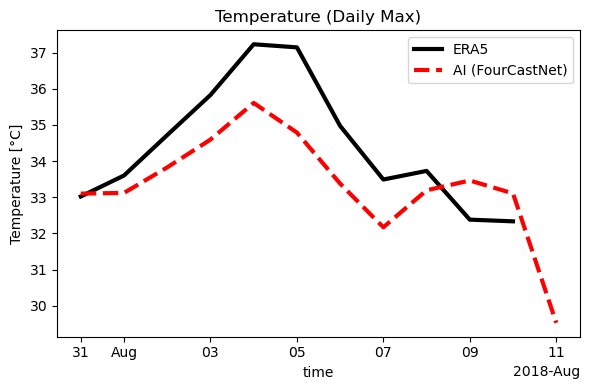

In [151]:
ds_t2m_ts = ds_t2m.max(dim=["latitude", "longitude"])
ds_true_ts = ds_true.max(dim=["latitude", "longitude"])

# plot
fig, ax = plt.subplots(figsize=(6,4))

ds_true_ts.plot(ax=ax, label="ERA5", linestyle="-", linewidth=3, color="black")
ds_t2m_ts.plot(ax=ax, label="AI (FourCastNet)", linestyle="--", linewidth=3, color="red")

ax.set(
    # ylim=[17, 35],
    ylabel="Temperature [°C]",
    title="Temperature (Daily Max)",
)


plt.tight_layout()
plt.legend()
plt.show()